# P-v plots

In this notebook, I shall attempt to work out how to generate p-v plots in first the inert case, before extending to the reactive case.

## Try this

In [1]:
from r3d2 import eos_defns, State, RiemannProblem, wave
from matplotlib import pyplot
import numpy
from scipy.integrate import odeint
%matplotlib notebook

In [2]:
gamma = 5.0/3.0
eos = eos_defns.eos_gamma_law(gamma)
test_1_U_left = State(10.0, 0.0, 0.0, 2.0, eos, label="L")
test_1_U_right = State(1.0, 0.0, 0.0, 0.5, eos, label="R")


test_1_rp = RiemannProblem(test_1_U_left, test_1_U_right)

In [3]:
def plot_P_v(rp):
    p_min=min([rp.state_l.p, rp.state_r.p, rp.p_star])
    p_max=max([rp.state_l.p, rp.state_r.p, rp.p_star])
    pyplot.plot(rp.state_l.v, rp.state_l.p, 'ko', label=r"$U_L$")
    pyplot.plot(rp.state_r.v, rp.state_r.p, 'k^', label=r"$U_R$")
    pyplot.plot(rp.state_star_l.v, rp.p_star, 'k*', label=r"$U_*$")
    dp = max(0.1, p_max-p_min)
    dp_fraction = min(0.5, 5*p_min)*dp
    print(dp_fraction, p_min-0.1*dp_fraction)
    p_l_1 = numpy.linspace(p_min-0.1*dp_fraction, rp.state_l.p-1e-3*dp_fraction)
    v_l_1 = numpy.zeros_like(p_l_1)
    p_l_2 = numpy.linspace(rp.state_l.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_l_2 = numpy.zeros_like(p_l_2)
    p_r_1 = numpy.linspace(p_min-0.1*dp_fraction, rp.state_r.p-1e-3*dp_fraction)
    v_r_1 = numpy.zeros_like(p_r_1)
    p_r_2 = numpy.linspace(rp.state_r.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_r_2 = numpy.zeros_like(p_r_2)
    for i, p in enumerate(p_l_1):
        w_all = odeint(wave.rarefaction_dwdp,
                       numpy.array([rp.state_l.rho, rp.state_l.v, rp.state_l.eps]),
                       [rp.state_l.p, p], rtol = 1e-12, atol = 1e-10,
                       args=((rp.state_l, 0)))
        v_l_1[i] = w_all[-1, 1]
    for i, p in enumerate(p_r_1):
        w_all = odeint(wave.rarefaction_dwdp,
                       numpy.array([rp.state_r.rho, rp.state_r.v, rp.state_r.eps]),
                       [rp.state_r.p, p], rtol = 1e-12, atol = 1e-10,
                       args=((rp.state_r, 2)))
        v_r_1[i] = w_all[-1, 1]
    for i, p in enumerate(p_l_2):
        j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_l, p,
                                                rp.state_l.eos)
        v_shock, q_end = wave.post_discontinuity_state(p, rp.state_l,
                                                  -1, "", j2,
                                                  rho, eps, diffp)
        v_l_2[i] = q_end.v
    for i, p in enumerate(p_r_2):
        j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_r, p,
                                                rp.state_r.eos)
        v_shock, q_end = wave.post_discontinuity_state(p, rp.state_r,
                                                  1, "", j2,
                                                  rho, eps, diffp)
        v_r_2[i] = q_end.v
    
    pyplot.plot(v_l_1, p_l_1, '--', label=r"${\cal R}_{\leftarrow}$")
    pyplot.plot(v_l_2, p_l_2, '-', label=r"${\cal S}_{\leftarrow}$")
    pyplot.plot(v_r_1, p_r_1, '--', label=r"${\cal R}_{\rightarrow}$")
    pyplot.plot(v_r_2, p_r_2, '-', label=r"${\cal S}_{\rightarrow}$")
    pyplot.xlabel(r"$v$")
    pyplot.ylabel(r"$p$")
    pyplot.ylim(0, p_max+0.1*dp_fraction)
    pyplot.legend()
    pyplot.show()

<IPython.core.display.Javascript object>


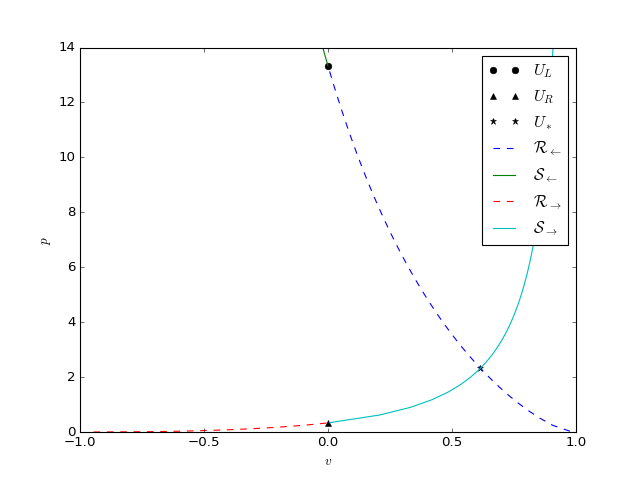

6.500000000000001 -0.31666666666666676


/Users/ih3/anaconda/lib/python3.4/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [4]:
plot_P_v(test_1_rp)

## Inert case

In [1]:
from r3d2 import eos_defns, State, RiemannProblem, wave
from matplotlib import pyplot as plt
% matplotlib inline
import numpy as np
from scipy.optimize import brentq
from IPython.display import display_png
from matplotlib.transforms import offset_copy
import matplotlib.transforms as mtrans
from scipy.integrate import odeint

In [2]:
gamma = 5.0/3.0
eos = eos_defns.eos_gamma_law(gamma)
test_1_U_left = State(10.0, 0.0, 0.0, 2.0, eos, label="L")
test_1_U_right = State(1.0, 0.0, 0.0, 1.5, eos, label="R")


test_1_rp = RiemannProblem(test_1_U_left, test_1_U_right)

Using equations for curves from Martí & Müller 2003:

$$
\mathcal{R}^S(p) = \frac{(1+v_S)A_\pm(p) - (1-v_S)}{(1+v_S)A_\pm(p)+(1-v_S)},
$$
where
$$
A_\pm(p) = \left(\frac{\left[\sqrt{\gamma-1} - c(p)\right]\left[\sqrt{\gamma-1} + c_{sS}\right]}{\left[\sqrt{\gamma-1} + c(p)\right]\left[\sqrt{\gamma-1} - c_{sS}\right]}\right)^{\pm\frac{2}{\sqrt{\gamma-1}}},
$$
where the sign + (-) corresponds to $S=L (S=R)$. $c_{sS}$ is the speed of sound of the state $\vec{v}_{sS}$, and $c(p)$ is given by
$$
c(p) = \left(\frac{\gamma(\gamma-1)p}{(\gamma-1)\rho_S(p/p_S)^{1/\gamma} + \gamma p}\right)^{1/2}.
$$
The family of shock states is then given by
$$
\mathcal{S}^S(p) = \left(h_SW_Sv_S^x \pm \frac{p-p_S}{j(p)\sqrt{1-V_\pm(p)^2}}\right)\left[h_SW_S + (p-p_S)\left(\frac{1}{\rho_SW_S} \pm \frac{v_S^x}{j(p)\sqrt{1-V_\pm(p)^2}}\right)\right]^{-1},
$$
where the + (-) sign corresponds to the $S = R (S=L)$ state. $V_\pm(p)$ are the shock velocities for shocks propagating to the right and left, and are given by
$$
V_\pm(p) = \frac{\rho_S^2W_S^2v_S^x \pm j(p)^2 \sqrt{1 + \rho_S^2W_S^2(1-(v_S^x)^2)/j(p)^2}}{\rho_S^2W_S^2 + j(p)^2}.
$$
Here, $j(p)$ is the mass flux across the shock 

In [27]:
def plot_P_v(rp, plot_rho=False):
    # if plot_rho is set to true, shall instead do a p-v plot where v = 1/rho is the specific volume.
    p_min=min([rp.state_l.p, rp.state_r.p, rp.p_star])
    p_max=max([rp.state_l.p, rp.state_r.p, rp.p_star])
    fig = plt.figure()
    if not plot_rho:
        plt.plot(rp.state_l.v, rp.state_l.p, 'ko', label=r"$U_L$")
        plt.plot(rp.state_r.v, rp.state_r.p, 'k^', label=r"$U_R$")
        plt.plot(rp.state_star_l.v, rp.p_star, 'k*', label=r"$U_*$")
        ax = fig.add_subplot(111)
        trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
        plt.text(rp.state_l.v, rp.state_l.p, r"$U_L$", transform=trans_offset, horizontalalignment='center',
                 verticalalignment='bottom')
        plt.text(rp.state_r.v, rp.state_r.p, r"$U_R$", transform=trans_offset, horizontalalignment='center',
                 verticalalignment='bottom')
        trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=20, y=-6, units='dots')
        plt.text(rp.state_star_l.v, rp.p_star, r"$U_*$", transform=trans_offset, horizontalalignment='center',
                 verticalalignment='bottom')
    else:
        plt.plot(rp.state_l.rho, rp.state_l.p, 'ko', label=r"$U_L$")
        plt.plot(rp.state_r.rho, rp.state_r.p, 'k^', label=r"$U_R$")
        plt.plot(rp.state_star_l.rho, rp.p_star, 'k*', label=r"$U_*$")
        ax = fig.add_subplot(111)
        trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
        plt.text(rp.state_l.rho, rp.state_l.p, r"$U_L$", transform=trans_offset, horizontalalignment='center',
                 verticalalignment='bottom')
        plt.text(rp.state_r.rho, rp.state_r.p, r"$U_R$", transform=trans_offset, horizontalalignment='center',
                 verticalalignment='bottom')
        trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=20, y=-6, units='dots')
        plt.text(rp.state_star_l.rho, rp.p_star, r"$U_*$", transform=trans_offset, horizontalalignment='center',
                 verticalalignment='bottom')

    dp = max(0.1, p_max-p_min)
    dp_fraction = min(0.5, 5*p_min)*dp
    #print(dp_fraction, p_min-0.1*dp_fraction)
    
    # TODO: make these an array? Can allocate by first identifying wave pattern, then move through sections of pattern 
    # (as I'd started to do in code below)
    
    p_l_1 = np.linspace(p_min-0.1*dp_fraction, rp.state_l.p-1e-3*dp_fraction)
    v_l_1 = np.zeros_like(p_l_1)
    p_l_2 = np.linspace(rp.state_l.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_l_2 = np.zeros_like(p_l_2)
    p_l_df = np.linspace(rp.state_star_l.p-1e-3**dp_fraction, rp.state_l.p-1e-3*dp_fraction)
    v_l_df = np.zeros_like(p_l_df)
    p_l_dt = np.linspace(rp.state_star_l.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_l_dt = np.zeros_like(p_l_dt)
    p_r_1 = np.linspace(p_min-0.1*dp_fraction, rp.state_r.p-1e-3*dp_fraction)
    v_r_1 = np.zeros_like(p_r_1)
    p_r_2 = np.linspace(rp.state_r.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_r_2 = np.zeros_like(p_r_2)
    p_r_df = np.linspace(rp.state_star_r.p-1e-3*dp_fraction, rp.state_r.p-1e-3*dp_fraction)
    v_r_df = np.zeros_like(p_r_df)
    p_r_dt = np.linspace(rp.state_star_r.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_r_dt = np.zeros_like(p_r_dt)
    # rarefaction curves
    for i, p in enumerate(p_l_1):
        w_all = odeint(wave.rarefaction_dwdp,
                       np.array([rp.state_l.rho, rp.state_l.v, rp.state_l.eps]),
                       [rp.state_l.p, p], rtol = 1e-12, atol = 1e-10,
                       args=((rp.state_l, 0)))
        v_l_1[i] = w_all[-1, 1]
    for i, p in enumerate(p_r_1):
        w_all = odeint(wave.rarefaction_dwdp,
                       np.array([rp.state_r.rho, rp.state_r.v, rp.state_r.eps]),
                       [rp.state_r.p, p], rtol = 1e-12, atol = 1e-10,
                       args=((rp.state_r, 2)))
        v_r_1[i] = w_all[-1, 1]
    # shock curves
    for i, p in enumerate(p_l_2):
        j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_l, p,
                                                rp.state_l.eos)
        v_shock, q_end = wave.post_discontinuity_state(p, rp.state_l,
                                                  -1, "", j2,
                                                  rho, eps, diffp)
        v_l_2[i] = q_end.v
    for i, p in enumerate(p_r_2):
        j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_r, p,
                                                rp.state_r.eos)
        v_shock, q_end = wave.post_discontinuity_state(p, rp.state_r,
                                                  1, "", j2,
                                                  rho, eps, diffp)
        v_r_2[i] = q_end.v
        
    
       
    # deflagration & detonation curves
    plot_burning = np.zeros(4, dtype=np.bool)
    if len(rp.waves[0].wave_sections) > 1 or rp.waves[0].wave_sections[0].type == 'Deflagration':
        plot_burning[0] = True
        for s in rp.waves[0].wave_sections:
            print(s.name)
            if s.type == 'Deflagration':
                print(s.wavespeed, s.q_start.p, s.q_end.p, s.q_end.v)
                plt.plot(s.q_end.v, s.q_end.p, 'ko', label=r"$CJDF$")
            elif s.type == 'Detonation':
                plt.plot(s.q_end.v, s.q_end.p, 'ko', label=r"$CJDT$")
            for i, p in enumerate(p_l_df):
                j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_star_l, p,
                                                        rp.state_star_l.eos)
                v_deflagration, q_end = wave.post_discontinuity_state(p, rp.state_star_l,
                                                          -1, "", j2,
                                                          rho, eps, diffp)

                if (-1*(q_end.wavespeed(s.wavenumber) - v_deflagration) < 0):
                    #print('hi')
                    p_cjdf = brentq(wave.deflagration_root, (1.0+1e-9)*p,
                                    (1.0-1e-9)*rp.state_star_l.p,
                                    args=(rp.state_star_l, rp.state_star_l.eos, s.wavenumber, ""))
                    print(p_cjdf)
                    #p_r_df[i] = p_cjdf
                    j2, rho, eps, dp = wave.mass_flux_squared(rp.state_star_l, p_cjdf, rp.state_star_l.eos)
                    v_deflagration, q_end = wave.post_discontinuity_state(p_cjdf, rp.state_star_l,
                                                                   -1, "", j2,
                                                                   rho, eps, diffp)#,
                                                                   #eos_end)
                v_l_df[i] = q_end.v
            
            
    if len(rp.waves[-1].wave_sections) > 1 or rp.waves[-1].wave_sections[0].type == 'Deflagration':
        plot_burning[1] = True
        for s in rp.waves[-1].wave_sections:
            print(s.name)
            if s.type == 'Deflagration':
                print(s.wavespeed, s.q_start.p, s.q_end.p, s.q_end.v)
                plt.plot(s.q_end.v, s.q_end.p, 'ko', label=r"$CJDF$")
            elif s.type == 'Detonation':
                plt.plot(s.q_end.v, s.q_end.p, 'ko', label=r"$CJDT$")
            for i, p in enumerate(p_r_df):
                j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_star_r, p,
                                                        rp.state_r.eos)
                v_deflagration, q_end = wave.post_discontinuity_state(p, rp.state_star_r,
                                                          1, "", j2,
                                                          rho, eps, diffp)

                if ((q_end.wavespeed(s.wavenumber) - v_deflagration) < 0):
                    p_cjdf = brentq(wave.deflagration_root, (1.0+1e-9)*p,
                                    (1.0-1e-9)*rp.state_star_r.p,
                                    args=(rp.state_star_r, rp.state_star_r.eos, s.wavenumber, ""))
                    print(p_cjdf)
                    #p_r_df[i] = p_cjdf
                    j2, rho, eps, dp = wave.mass_flux_squared(rp.state_star_r, p_cjdf, rp.state_star_r.eos)
                    v_deflagration, q_end = wave.post_discontinuity_state(p_cjdf, rp.state_star_r,
                                                                   1, "", j2,
                                                                   rho, eps, diffp)#,
                                                                   #eos_end)
                v_r_df[i] = q_end.v
    
    if plot_rho:
        gamma = 1 + rp.state_l.p / (rp.state_l.rho * rp.state_l.eps)
        K = rp.state_l.p/(rp.state_l.rho**gamma)
        v_l_1 = 1/(p_l_1/K)**(1/gamma)
        v_l_2 = 1/(p_l_2/K)**(1/gamma)
        
        gamma = 1 + rp.state_l.p / (rp.state_l.rho * rp.state_l.eps)
        K = rp.state_r.p/(rp.state_r.rho**gamma)
        v_r_1 = 1/(p_r_1/K)**(1/gamma)
        v_r_2 = 1/(p_r_2/K)**(1/gamma)
    
    plt.plot(v_l_1, p_l_1, '--', label=r"${\cal R}_{\leftarrow}$")
    plt.plot(v_l_2, p_l_2, '-', label=r"${\cal S}_{\leftarrow}$")
    plt.plot(v_r_1, p_r_1, '--', label=r"${\cal R}_{\rightarrow}$")
    plt.plot(v_r_2, p_r_2, '-', label=r"${\cal S}_{\rightarrow}$")
    #if plot_burning[0]: plt.plot(v_l_df, p_l_df, '-', label=r"${\cal DF}_{\leftarrow}$")
    #if plot_burning[1]: plt.plot(v_r_df, p_r_df, '-', label=r"${\cal DF}_{\rightarrow}$")
    #if plot_burning[2]: plt.plot(v_l_dt, p_l_dt, '-', label=r"${\cal DT}_{\leftarrow}$")
    #if plot_burning[3]: plt.plot(v_r_dt, p_r_dt, '-', label=r"${\cal DT}_{\rightarrow}$")
    plt.xlabel(r"$v$")
    plt.ylabel(r"$p$")
    plt.ylim(0, p_max+0.1*dp_fraction)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()



In [171]:
# not very efficient as goes through every case individually, but kind of works
def plot_P_v(rp):
    p_min=min([rp.state_l.p, rp.state_r.p, rp.p_star])
    p_max=max([rp.state_l.p, rp.state_r.p, rp.p_star])
    v_min=min([rp.state_l.v, rp.state_r.v, rp.state_star_l.v, rp.state_star_r.v])
    v_max=max([rp.state_l.v, rp.state_r.v, rp.state_star_l.v, rp.state_star_r.v])
    fig = plt.figure()
    
    # plot L, R and * states
    plt.plot(rp.state_l.v, rp.state_l.p, 'ko', label=r"$U_L$")
    plt.plot(rp.state_r.v, rp.state_r.p, 'k^', label=r"$U_R$")
    plt.plot(rp.state_star_l.v, rp.p_star, 'k*', label=r"$U_*$")
    ax = fig.add_subplot(111)
    trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
    plt.text(rp.state_l.v, rp.state_l.p, r"$U_L$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
    plt.text(rp.state_r.v, rp.state_r.p, r"$U_R$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
    trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=20, y=-6, units='dots')
    plt.text(rp.state_star_l.v, rp.p_star, r"$U_*$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')

    dp = max(0.1, p_max-p_min)
    dp_fraction = min(0.5, 5*p_min)*dp
    dv = max(0.1, v_max-v_min)
    dv_fraction = min(0.5, 5*v_min)*dv
    #print(dp_fraction, p_min-0.1*dp_fraction)
    
    # TODO: make these an array? Can allocate by first identifying wave pattern, then move through sections of pattern 
    # (as I'd started to do in code below)
    
    """
    # rarefaction/deflagration
    pr = np.array([])
    vr = np.array([])
    # shock/detonation
    ps = np.array([])
    vs = np.array([])
    # look at wave pattern
    # left wave
    if len(rp.waves[0].wave_sections) == 1: #non-burning
        pr.append(np.linspace(p_min-0.1*dp_fraction, rp.state_l.p-1e-3*dp_fraction))
        ps.append(np.linspace(rp.state_l.p+1e-3*dp_fraction, p_max+0.1*dp_fraction))
        vr.append(np.zeros_like(pr[-1,:]))
        vs.append(np.zeros_like(ps[-1,:]))
        
        for i, p in enumerate(p_l_1):
        w_all = odeint(wave.rarefaction_dwdp,
                       np.array([rp.state_l.rho, rp.state_l.v, rp.state_l.eps]),
                       [rp.state_l.p, p], rtol = 1e-12, atol = 1e-10,
                       args=((rp.state_l, 0)))
        v_l_1[i] = w_all[-1, 1]
        
    else:
        # find CJ point
        for s in rp.waves[0].wave_sections:
            if s.type == 'Deflagration' or s.type == 'Detonation':
                CJ_v, CJ_p = s.q_end.v, s.q_end.p
                plt.plot(s.q_end.v, s.q_end.p, 'ko', label=r"$CJ$")
                break
    """            
            
    p_l_1 = np.linspace(p_min-0.1*dp_fraction, rp.state_l.p-1e-3*dp_fraction)
    v_l_1 = np.zeros_like(p_l_1)
    p_l_2 = np.linspace(rp.state_l.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_l_2 = np.zeros_like(p_l_2)
    #p_l_df = np.linspace(p_min-0.1*dp_fraction, rp.state_l.p-1e-3*dp_fraction) # want this to go to CJ rather than pmin
    #v_l_df = np.zeros_like(p_l_df)
    #p_l_dt = np.linspace(rp.state_l.p+1e-3*dp_fraction, p_max+0.1*dp_fraction) # want this to go from CJ rather than pmax
    #v_l_dt = np.zeros_like(p_l_dt)
    p_r_1 = np.linspace(p_min-0.1*dp_fraction, rp.state_r.p-1e-3*dp_fraction)
    v_r_1 = np.zeros_like(p_r_1)
    p_r_2 = np.linspace(rp.state_r.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
    v_r_2 = np.zeros_like(p_r_2)
    #p_r_df = np.linspace(p_min-0.1*dp_fraction, rp.state_r.p-1e-3*dp_fraction) # want this to go to CJ rather than pmin
    #v_r_df = np.zeros_like(p_r_df)
    #p_r_dt = np.linspace(rp.state_r.p+1e-3*dp_fraction, p_max+0.1*dp_fraction) # want this to go from CJ rather than pmax
    #v_r_dt = np.zeros_like(p_r_dt)
    # rarefaction curves
    for i, p in enumerate(p_l_1):
        w_all = odeint(wave.rarefaction_dwdp,
                       np.array([rp.state_l.rho, rp.state_l.v, rp.state_l.eps]),
                       [rp.state_l.p, p], rtol = 1e-12, atol = 1e-10,
                       args=((rp.state_l, 0)))
        v_l_1[i] = w_all[-1, 1]
    for i, p in enumerate(p_r_1):
        w_all = odeint(wave.rarefaction_dwdp,
                       np.array([rp.state_r.rho, rp.state_r.v, rp.state_r.eps]),
                       [rp.state_r.p, p], rtol = 1e-12, atol = 1e-10,
                       args=((rp.state_r, 2)))
        v_r_1[i] = w_all[-1, 1]
    # shock curves
    for i, p in enumerate(p_l_2):
        j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_l, p,
                                                rp.state_l.eos)
        v_shock, q_end = wave.post_discontinuity_state(p, rp.state_l,
                                                  -1, "", j2,
                                                  rho, eps, diffp)
        v_l_2[i] = q_end.v
    for i, p in enumerate(p_r_2):
        j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_r, p,
                                                rp.state_r.eos)
        v_shock, q_end = wave.post_discontinuity_state(p, rp.state_r,
                                                  1, "", j2,
                                                  rho, eps, diffp)
        v_r_2[i] = q_end.v
        
    
       
    # deflagration & detonation curves
    plot_burning = np.zeros(4, dtype=np.bool)
    if len(rp.waves[0].wave_sections) == 2 or rp.waves[0].wave_sections[0].type == 'Deflagration':
        plot_burning[0] = True
        plot_burning[2] = True
        for s in rp.waves[0].wave_sections:
            if s.type == 'Deflagration':
                CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                CJ_q = s.q_end
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDF$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                p_l_df = np.linspace(CJ_p+1e-3*dp_fraction, rp.state_l.p-1e-3*dp_fraction) 
                v_l_df = np.zeros_like(p_l_df)
                p_l_dt = np.linspace(rp.state_l.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_l_dt = np.zeros_like(p_l_dt)
                # cut off rarefaction at CJ point
                p_l_1 = np.linspace(p_min-0.1*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_l_1 = np.zeros_like(p_l_1)
                for i, p in enumerate(p_l_1):
                    w_all = odeint(wave.rarefaction_dwdp,
                                   np.array([CJ_rho, CJ_v, CJ_eps]),
                                   [CJ_p, p], rtol = 1e-12, atol = 1e-10,
                                   args=((CJ_q, 0)))
                    v_l_1[i] = w_all[-1, 1]
            elif s.type == 'Detonation':
                CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                CJ_q = s.q_end
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDT$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                p_l_dt = np.linspace(rp.state_l.p+1e-3*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_l_dt = np.zeros_like(p_l_dt)
                p_l_df = np.linspace(p_min-0.1*dp_fraction, rp.state_l.p-1e-3*dp_fraction) 
                v_l_df = np.zeros_like(p_l_df)
                # cut off shock at CJ point
                p_l_2 = np.linspace(CJ_p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_l_2 = np.zeros_like(p_l_2)
            for i, p in enumerate(p_l_df):
                j2, rho, eps, diffp = wave.mass_flux_squared(CJ_q, p,
                                                        CJ_q.eos)
                v_deflagration, q_end = wave.post_discontinuity_state(p, CJ_q,
                                                          -1, "", j2,
                                                          rho, eps, diffp)

                if (-1*(q_end.wavespeed(s.wavenumber) - v_deflagration) < 0):
                    p_cjdf = brentq(wave.deflagration_root, (1.0+1e-9)*p,
                                    (1.0-1e-9)*CJ_p,
                                    args=(CJ_q, CJ_q.eos, s.wavenumber, ""))
                    j2, rho, eps, dp = wave.mass_flux_squared(CJ_q, p_cjdf, CJ_q.eos)
                    v_deflagration, q_end = wave.post_discontinuity_state(p_cjdf, CJ_q,
                                                                   -1, "", j2,
                                                                   rho, eps, diffp)
                v_l_df[i] = q_end.v
            for i, p in enumerate(p_l_dt):
                j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_l, p,
                                                        rp.state_l.eos)
                if j2 < 0:
                    # The single detonation is unphysical - must be unstable weak
                    # detonation. So skip the calculation and make sure the CJ
                    # calculation runs
                    q_unknown = deepcopy(rp.state_l)
                    v_detonation = q_unknown.wavespeed(self.wavenumber) - 1
                else:
                    v_detonation, q_unknown = wave.post_discontinuity_state(p, rp.state_l,
                                            -1, "", j2,
                                            rho, eps, dp,
                                            rp.state_l.eos)

                if (-1*(q_end.wavespeed(s.wavenumber) - v_detonation) < 0):
                    pmin = (1.0+1e-9)*min(rp.state_l.p, p)
                    pmax = max(rp.state_l.p, p)
                    fmin = wave.deflagration_root(pmin, rp.state_l, rp.state_l.eos, s.wavenumber, "")
                    fmax = wave.deflagration_root(pmax, rp.state_l, rp.state_l.eos, s.wavenumber, "")
                    while fmin * fmax > 0:
                        pmax *= 2.0
                        fmax = wave.deflagration_root(pmax, rp.state_l, rp.state_l.eos, s.wavenumber, "")
                    p_cjdt = brentq(wave.deflagration_root, pmin, pmax,
                                    args=(rp.state_l, rp.state_l.eos, s.wavenumber, ""))
                    j2, rho, eps, dp = wave.mass_flux_squared(rp.state_l, p_cjdt, rp.state_l.eos)
                    v_detonation, q_unknown = wave.post_discontinuity_state(p_cjdt, rp.state_l,
                                           -1, "", j2,
                                           rho, eps, dp,
                                           rp.state_l.eos)
                v_l_dt[i] = q_end.v
            
    # right wave        
    if len(rp.waves[-1].wave_sections) == 2 or rp.waves[-1].wave_sections[0].type == 'Deflagration':
        plot_burning[1] = True
        plot_burning[3] = True
        for s in rp.waves[-1].wave_sections:
            #print(s.name)
            if s.type == 'Deflagration':
                CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDF$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                p_r_df = np.linspace(CJ_p+1e-3*dp_fraction, rp.state_r.p-1e-3*dp_fraction) 
                v_r_df = np.zeros_like(p_r_df)
                p_r_dt = np.linspace(rp.state_r.p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_r_dt = np.zeros_like(p_r_dt)
                # cut off rarefaction at CJ point
                p_r_1 = np.linspace(p_min-0.1*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_r_1 = np.zeros_like(p_r_1)
                
                for i, p in enumerate(p_r_1):
                    w_all = odeint(wave.rarefaction_dwdp,
                                   np.array([CJ_rho, CJ_v, CJ_eps]),
                                   [CJ_p, p], rtol = 1e-12, atol = 1e-10,
                                   args=((s.q_end, 2)))
                    v_r_1[i] = w_all[-1, 1]
            elif s.type == 'Detonation':
                CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDT$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                p_r_dt = np.linspace(rp.state_r.p+1e-3*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_r_dt = np.zeros_like(p_r_dt)
                p_r_df = np.linspace(p_min-0.1*dp_fraction, rp.state_r.p-1e-3*dp_fraction) 
                v_r_df = np.zeros_like(p_r_df)
                # cut off shock at CJ point
                p_r_2 = np.linspace(CJ_p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_r_2 = np.zeros_like(p_r_2)
            for i, p in enumerate(p_r_df):
                j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_star_r, p,
                                                        rp.state_r.eos)
                v_deflagration, q_end = wave.post_discontinuity_state(p, rp.state_star_r,
                                                          1, "", j2,
                                                          rho, eps, diffp)

                if ((q_end.wavespeed(s.wavenumber) - v_deflagration) < 0):
                    p_cjdf = brentq(wave.deflagration_root, (1.0+1e-9)*p,
                                    (1.0-1e-9)*rp.state_star_r.p,
                                    args=(rp.state_star_r, rp.state_star_r.eos, s.wavenumber, ""))
                    j2, rho, eps, dp = wave.mass_flux_squared(rp.state_star_r, p_cjdf, rp.state_star_r.eos)
                    v_deflagration, q_end = wave.post_discontinuity_state(p_cjdf, rp.state_star_r,
                                                                   1, "", j2,
                                                                   rho, eps, diffp)
                v_r_df[i] = q_end.v
                
            for i, p in enumerate(p_r_dt):
                j2, rho, eps, diffp = wave.mass_flux_squared(rp.state_r, p,
                                                        rp.state_r.eos)
                if j2 < 0:
                    # The single detonation is unphysical - must be unstable weak
                    # detonation. So skip the calculation and make sure the CJ
                    # calculation runs
                    q_unknown = deepcopy(rp.state_r)
                    v_detonation = q_unknown.wavespeed(self.wavenumber) + 1
                else:
                    v_detonation, q_unknown = wave.post_discontinuity_state(p, rp.state_r,
                                            1, "", j2,
                                            rho, eps, dp,
                                            rp.state_r.eos)

                if ((q_end.wavespeed(s.wavenumber) - v_detonation) < 0):
                    pmin = (1.0+1e-9)*min(rp.state_r.p, p)
                    pmax = max(rp.state_r.p, p)
                    fmin = wave.deflagration_root(pmin, rp.state_r, rp.state_r.eos, s.wavenumber, "")
                    fmax = wave.deflagration_root(pmax, rp.state_r, rp.state_r.eos, s.wavenumber, "")
                    while fmin * fmax > 0:
                        pmax *= 2.0
                        fmax = wave.deflagration_root(pmax, rp.state_r, rp.state_r.eos, s.wavenumber, "")
                    p_cjdt = brentq(wave.deflagration_root, pmin, pmax,
                                    args=(rp.state_r, rp.state_r.eos, s.wavenumber, ""))
                    j2, rho, eps, dp = wave.mass_flux_squared(rp.state_r, p_cjdt, rp.state_r.eos)
                    v_detonation, q_unknown = wave.post_discontinuity_state(p_cjdt, rp.state_r,
                                           1, "", j2,
                                           rho, eps, dp,
                                           rp.state_r.eos)
                v_r_dt[i] = q_end.v
            

    # now for weird 3 wave case 
    if len(rp.waves[0].wave_sections) == 3:
        for s in rp.waves[0].wave_sections:
            CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
            if s.type == 'Deflagration':
                #CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDF$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                # cut off rarefaction and shock at CJ point
                p_l_1 = np.linspace(p_min-0.1*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_l_1 = np.zeros_like(p_l_1)
                p_l_2 = np.linspace(CJ_p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_l_2 = np.zeros_like(p_l_2)
                """for i, p in enumerate(p_l_1):
                    w_all = odeint(wave.rarefaction_dwdp,
                                   np.array([CJ_rho, CJ_v, CJ_eps]),
                                   [CJ_p, p], rtol = 1e-12, atol = 1e-10,
                                   args=((s.q_end, 0)))
                    v_l_1[i] = w_all[-1, 1]
                for i, p in enumerate(p_l_2):
                    j2, rho, eps, diffp = wave.mass_flux_squared(s.q_end, p,
                                                            s.q_end.eos)
                    v_shock, q_end = wave.post_discontinuity_state(p, s.q_end,
                                                              -1, "", j2,
                                                              rho, eps, diffp)
                    v_l_2[i] = q_end.v"""
            elif s.type == 'Detonation':
                #CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDT$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                p_l_dt = np.linspace(rp.state_l.p+1e-3*dp_fraction, CJ_p+1e-3*dp_fraction)
                v_l_dt = np.zeros_like(p_l_dt)
                # cut off rarefaction and shock at CJ point
                p_l_1 = np.linspace(CJ_p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_l_1 = np.zeros_like(p_l_1)
                p_l_2 = np.linspace(p_min-0.1*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_l_2 = np.zeros_like(p_l_2)
                
            for i, p in enumerate(p_l_1):
                w_all = odeint(wave.rarefaction_dwdp,
                               np.array([CJ_rho, CJ_v, CJ_eps]),
                               [CJ_p, p], rtol = 1e-12, atol = 1e-10,
                               args=((s.q_end, 0)))
                v_l_1[i] = w_all[-1, 1]
            for i, p in enumerate(p_l_2):
                j2, rho, eps, diffp = wave.mass_flux_squared(s.q_end, p,
                                                        s.q_end.eos)
                v_shock, q_end = wave.post_discontinuity_state(p, s.q_end,
                                                          -1, "", j2,
                                                          rho, eps, diffp)
                v_l_2[i] = q_end.v
    # right wave        
    if len(rp.waves[-1].wave_sections) == 3:
        for s in rp.waves[-1].wave_sections:
            CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
            if s.type == 'Deflagration':
                #CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDF$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                # cut off rarefaction at CJ point
                p_r_1 = np.linspace(p_min-0.1*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_r_1 = np.zeros_like(p_r_1)
                p_r_2 = np.linspace(CJ_p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_r_2 = np.zeros_like(p_r_2)
                
            elif s.type == 'Detonation':
                #CJ_v, CJ_p, CJ_rho, CJ_eps = s.q_end.v, s.q_end.p, s.q_end.rho, s.q_end.eps
                plt.plot(CJ_v, CJ_p, 'ko', label=r"$CJDT$")
                trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-15, y=-6, units='dots')
                plt.text(CJ_v, CJ_p, r"$CJ$", transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
                # cut off shock at CJ point
                p_r_1 = np.linspace(CJ_p+1e-3*dp_fraction, p_max+0.1*dp_fraction)
                v_r_1 = np.zeros_like(p_r_1)
                p_r_2 = np.linspace(p_min-0.1*dp_fraction, CJ_p-1e-3*dp_fraction)
                v_r_2 = np.zeros_like(p_r_2)
                
            for i, p in enumerate(p_r_1):
                w_all = odeint(wave.rarefaction_dwdp,
                               np.array([CJ_rho, CJ_v, CJ_eps]),
                               [CJ_p, p], rtol = 1e-12, atol = 1e-10,
                               args=((s.q_end, 2)))
                v_r_1[i] = w_all[-1, 1]
            for i, p in enumerate(p_r_2):
                j2, rho, eps, diffp = wave.mass_flux_squared(s.q_end, p,
                                                        s.q_end.eos)
                v_shock, q_end = wave.post_discontinuity_state(p, s.q_end,
                                                          1, "", j2,
                                                          rho, eps, diffp)
                v_r_2[i] = q_end.v
    
    
    plt.plot(v_l_1, p_l_1, '--', label=r"${\cal R}_{\leftarrow}$")
    plt.plot(v_l_2, p_l_2, '-', label=r"${\cal S}_{\leftarrow}$")
    plt.plot(v_r_1, p_r_1, '--', label=r"${\cal R}_{\rightarrow}$")
    plt.plot(v_r_2, p_r_2, '-', label=r"${\cal S}_{\rightarrow}$")
    if plot_burning[0]: plt.plot(v_l_df, p_l_df, '-', label=r"${\cal DF}_{\leftarrow}$")
    if plot_burning[1]: plt.plot(v_r_df, p_r_df, '-', label=r"${\cal DF}_{\rightarrow}$")
    if plot_burning[2]: plt.plot(v_l_dt, p_l_dt, '-', label=r"${\cal DT}_{\leftarrow}$")
    if plot_burning[3]: plt.plot(v_r_dt, p_r_dt, '-', label=r"${\cal DT}_{\rightarrow}$")
    plt.xlabel(r"$v$")
    plt.ylabel(r"$p$")
    plt.ylim(0, p_max+0.1*dp_fraction)
    plt.xlim(v_min-0.5*dv, v_max+0.5*dv)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()


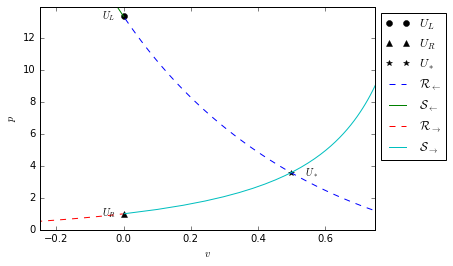

In [172]:
plot_P_v(test_1_rp)

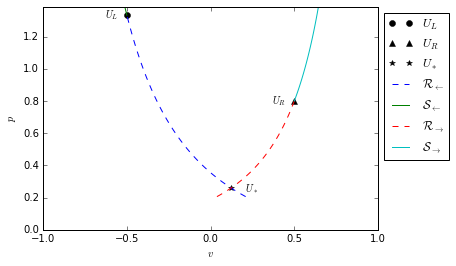

In [173]:
gamma_air = 1.4
eos_air = eos_defns.eos_gamma_law(gamma_air)
U_vary_eos_L = State(1.0, -0.5, 0.0, 2.0, eos, label="L")
U_vary_eos_R = State(1.0, +0.5, 0.0, 2.0, eos_air, label="R")
test_vary_eos_rp = RiemannProblem(U_vary_eos_L, U_vary_eos_R)
plot_P_v(test_vary_eos_rp)

## Burnt case

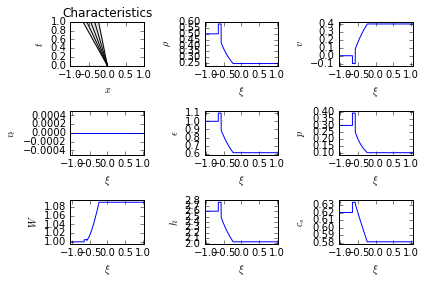

In [174]:
eos = eos_defns.eos_gamma_law(5.0/3.0)
eos_reactive = eos_defns.eos_gamma_law_react(5.0/3.0, 0.1, 1.0, 1.0, eos)
U_reactive_left = State(0.5, 0.0, 0.0, 1.0, eos_reactive)
U_reactive_right = State(0.24316548798524526, 0.39922932397353039, 0.0,
                    0.61686385086179807, eos)
test_precursor_rp = RiemannProblem(U_reactive_left, U_reactive_right)
test_precursor_rp

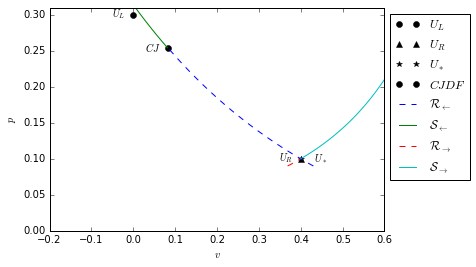

In [175]:
plot_P_v(test_precursor_rp)

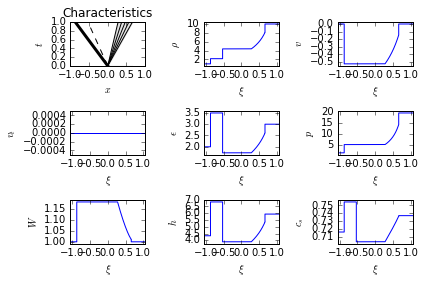

In [176]:
q_unburnt = 0.1
gamma = 5/3
Cv = 1.0
t_ignition = 2
eos_burnt = eos_defns.eos_gamma_law(gamma)
eos_unburnt = eos_defns.eos_gamma_law_react(gamma, q_unburnt, Cv, t_ignition, eos_burnt)
U_reactive_left = State(1, 0, 0, 2, eos_burnt)
U_reactive_right = State(10, 0, 0, 3, eos_unburnt)
test_reactive_rp = RiemannProblem(U_reactive_left, U_reactive_right)
test_reactive_rp

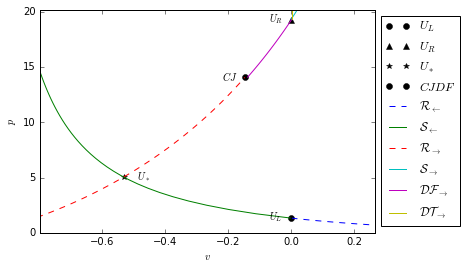

In [177]:
plot_P_v(test_reactive_rp)

/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in double_scalars


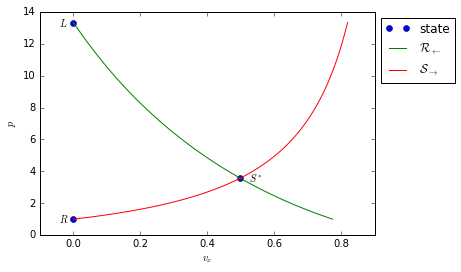

In [58]:
# shock curves 
def taub(h, gamma, p, state_a):
    return h**2 * (1 + (gamma-1) * (state_a.p-p) / (gamma * p)) - h * (gamma-1) * (state_a.p-p) / \
           (gamma*p) + state_a.h * (state_a.p-p) / state_a.rho - state_a.h**2
    
def shock_vs(gamma, p, state_a, old_h):
    #hs = np.linspace(old_h*0.3, old_h*2, num=100, endpoint=True)
    #plt.plot(hs, taub(hs, gamma, p, state_a))
    #plt.show()
    
    
    h = brentq(taub, old_h*0.3, old_h*1.1, args=(gamma, p, state_a))
    #K = state_a.p/state_a.rho**gamma
    #rho = (p/K)**(1/gamma)
    j = np.sqrt((state_a.p - p) / ((state_a.h**2-h**2)/(state_a.p-p) - 2*state_a.h/state_a.rho))
    
    # find Lorentz factor of shock
    vsp = (state_a.rho**2 * state_a.W_lorentz**2 * state_a.v + \
          j**2 * np.sqrt(1 + state_a.rho**2 * state_a.W_lorentz**2 * (1-state_a.v**2)/j**2)) / \
          (state_a.rho**2 * state_a.W_lorentz**2 + j**2)
    vsm = (state_a.rho**2 * state_a.W_lorentz**2 * state_a.v - \
          j**2 * np.sqrt(1 + state_a.rho**2 * state_a.W_lorentz**2 * (1-state_a.v**2)/j**2)) / \
          (state_a.rho**2 * state_a.W_lorentz**2 + j**2)
    
    return (state_a.h * state_a.W_lorentz * state_a.v + (p-state_a.p)/(j*np.sqrt(1-vsp**2))) / \
           (state_a.h*state_a.W_lorentz + \
         (p-state_a.p) * (1/(state_a.rho*state_a.W_lorentz) + state_a.v/(j * np.sqrt(1-vsp**2)))), \
           (state_a.h * state_a.W_lorentz * state_a.v - (p-state_a.p)/(j*np.sqrt(1-vsm**2))) / \
           (state_a.h*state_a.W_lorentz + \
         (p-state_a.p) * (1/(state_a.rho*state_a.W_lorentz) - state_a.v/(j * np.sqrt(1-vsm**2)))), h
    
    

# rarefaction curves
def vpm(gamma, eos, p, state_a):
    cs = find_cs(gamma, p, state_a)
    cs_a = eos['cs_from_rho_eps'](state_a.rho, state_a.eps)
    A = (np.sqrt(gamma-1) - cs) * (np.sqrt(gamma-1) + cs_a) / ((np.sqrt(gamma-1) + cs) * (np.sqrt(gamma-1) - cs_a))
    
    Ap, Am = A**(2 / np.sqrt(gamma-1)), A**(-2 / np.sqrt(gamma-1))
    
    va = state_a.v
    
    vp = ((1+va) * Ap - (1-va)) / ((1+va) * Ap + (1-va))
    vm = ((1+va) * Am - (1-va)) / ((1+va) * Am + (1-va))
    
    return vp, vm

def find_cs(gamma, p, state_a):
    return np.sqrt(gamma*(gamma-1)*p / ((gamma-1) *state_a.rho * (p/state_a.p)**(1/gamma) + gamma*p))

def plot_pvx(rp, gamma_l, gamma_r, eos_l, eos_r):
    # test what the waves are so know what to draw 
    types = []
    directions = []
    vs = []
    for w in rp.waves:
        for s in w.wave_sections:
            types.append(s.type)
            directions.append(s.wavenumber)
            vs.append(s.wavespeed)
    #print(types, directions)
    
    # find p, vxs of states in wave 
    ps = np.array([rp.state_l.p, rp.p_star, rp.state_r.p])
    #ps = np.array([wave.q_l.p for wave in rp.waves]) #, rp.waves[-1].q_r.p]
    #p2s = np.array([wave.q_r.p for wave in rp.waves]) 
    vxs = np.array([rp.state_l.v, rp.state_star_r.v, rp.state_r.v])
    #vxs = np.array([wave.q_l.v for wave in rp.waves])
    #vx2s = np.array([wave.q_r.v for wave in rp.waves])
            
    
    # Rarefactions
    vr = rp.waves[0].wavespeed[0]
    test_ps = np.linspace(min(ps), max(ps), num=100, endpoint=True)
    test_vps, _ = vpm(gamma_l, eos_l, test_ps, rp.waves[0].q_l)#-vr
    _, test_vms = vpm(gamma_r, eos_r, test_ps, rp.waves[-1].q_r)#-vr
    
    
    # shock speed
    old_hr = rp.waves[-1].q_r.h
    old_hl = rp.waves[0].q_l.h
    test_vs = np.zeros_like(test_ps)
    test_vs2 = np.zeros_like(test_ps)
    
    # intialise 1st points on curves
    test_vs[0] = rp.waves[-1].q_r.v
    test_vs2[0] = rp.waves[0].q_l.v
    
    for i in range(1, len(test_ps)):
        # march from right state 
        #shock_vs(gamma, test_ps[i], rp.waves[-1].q_r, old_hr)
        test_vs[i], _, old_hr = shock_vs(gamma_r, test_ps[i], rp.waves[-1].q_r, old_hr)
        _, test_vs2[i], old_hl = shock_vs(gamma_l, test_ps[i], rp.waves[0].q_l, old_hl)
        
    def flatten_pattern(rprob):
        # flatten patterns
        flat_patterns = []
        for w in rprob.waves:
            for s in w.wave_sections:
                if not s.trivial:
                    flat_patterns.append(s)
        return flat_patterns
        
    sections = flatten_pattern(rp)
    # now going to try to automate all this....
    vs = []
    wlabels = [r'state']
    for i in range(len(sections)):
        vs.append([])
        s = sections[i]
        if s.type is not 'Contact':   
            wlabels.append(r'$' + s.name + '$')
        if s.type == 'Rarefaction':
            if s.wavenumber == 0: # moving left
                vs[i], _ = vpm(gamma_l, eos_l, test_ps, s.q_start)
            else: # moving right
                _, vs[i] = vpm(gamma_r, eos_r, test_ps, s.q_start)
        elif s.type == 'Shock':
            if s.wavenumber == 0:
                #old_hr = rp.waves[-1].q_r.h
                old_h = s.q_start.h
                vs[i] = np.zeros_like(test_ps)
                #test_vs2 = np.zeros_like(test_ps)

                # intialise 1st points on curves
                vs[i,0] = s.q_start.v
                #test_vs2[0] = rp.waves[0].q_l.v
                
                for j in range(1, len(test_ps)):
                    _, vs[i,j], old_h = shock_vs(gamma_l, test_ps[j], s.q_start, old_h)
            else:
                old_h = s.q_start.h
                vs[i] = np.zeros_like(test_ps)
                #print(vs[i])

                # intialise 1st points on curves
                vs[i][0] = s.q_start.v
                for j in range(1, len(test_ps)):
                    vs[i][j], _, old_h = shock_vs(gamma_r, test_ps[j], s.q_start, old_h)
        elif s.type == 'Deflagration':
            print(s.wavespeed)

    #plt.plot(vxs, ps, '-o', test_vps, test_ps, test_vms, test_ps, test_vs, test_ps, test_vs2, test_ps)
    fig = plt.figure() 
    labels = [r'$L$', r'$S^*$', r'$R$']
    ax = fig.add_subplot(111)
    #ax.plot(vxs, ps, 'o', test_vps, test_ps, test_vs, test_ps)
    #ax.plot(vxs, ps, 'o', test_vps, test_ps, test_vms, test_ps)#, test_vs, test_ps, test_vs2, test_ps)
    ax.plot(vxs, ps, 'o', vs[0], test_ps, vs[-1], test_ps)
    trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=-10, y=-6, units='dots')
    plt.text(vxs[0], ps[0], labels[0], transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
    plt.text(vxs[-1], ps[-1], labels[-1], transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
    trans_offset = mtrans.offset_copy(ax.transData, fig=fig, x=16, y=-6, units='dots')
    plt.text(vxs[1], ps[1], labels[1], transform=trans_offset, horizontalalignment='center',
             verticalalignment='bottom')
    plt.xlabel(r'$v_x$')
    plt.ylabel(r'$p$')
    plt.xlim([min(vxs)-0.1, None])
    plt.legend(wlabels, bbox_to_anchor=(1, 1), loc='upper left')
    #plt.legend(['L, R', r'$\mathcal{R}_\leftarrow$', r'$\mathcal{S}_\rightarrow$'])
    
plot_pvx(test_1_rp, gamma, gamma, eos, eos)


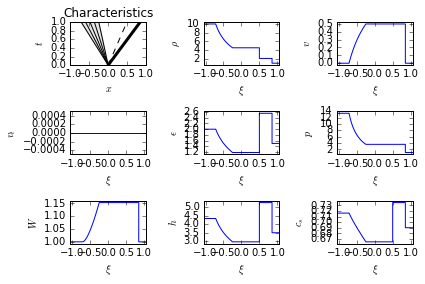

In [9]:
test_1_rp

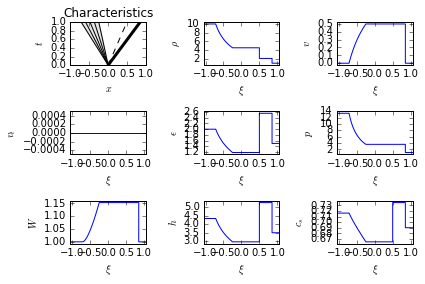

In [10]:
display_png(test_1_rp)

/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/alice/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in double_scalars


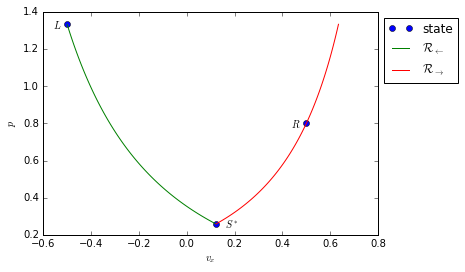

In [11]:
gamma_air = 1.4
eos_air = eos_defns.eos_gamma_law(gamma_air)
U_vary_eos_L = State(1.0, -0.5, 0.0, 2.0, eos, label="L")
U_vary_eos_R = State(1.0, +0.5, 0.0, 2.0, eos_air, label="R")
test_vary_eos_rp = RiemannProblem(U_vary_eos_L, U_vary_eos_R)
plot_pvx(test_vary_eos_rp, gamma, gamma_air, eos, eos_air)

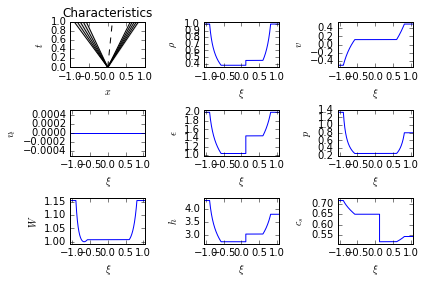

In [12]:
test_vary_eos_rp